In [1]:
from __future__ import division

import collections
import numpy as np
import matplotlib.pyplot as plt

## NN libs
import keras
from keras import backend as K
from keras import regularizers
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import TensorBoard

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import config
import os, numpy as np, pandas, sklearn, scipy.signal as signal
import mido
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# local libs
import config, models, setup, compression, ncd_evaluation
import midi
import midi.decode
from midi import generators as g
from utils import io, models_io, utils, plot, string
from capsule.layers import Capsule, Length
from capsule.capsulefunctions import squash, softmax, margin_loss

In [4]:
context = setup.init(max_bars=4)

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_timestesp = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]

Setting up params

max min f 20.0 0.25
 >> Context(max_t=4.0, dt=0.025, n_timesteps=160, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
 sample length:  160.000000
 max_f: 20.000000, min_f: 0.250000


In [5]:
n = 500 * 2
dim4 = True
multiTrack = True
reduce_dims = midi.ReduceDimsOptions.NONE # GLOBAL
dn = 'drum_midi/'
v = None # float | None
x_train, labels = setup.import_data(context, n, dim4=dim4, reduce_dims=reduce_dims, 
    dirname=dn, multiTrack=multiTrack, velocity=v, r=True)


Importing midi-data
walk_and_search(../datasets/drum_midi/)
path ../datasets/drum_midi/
path ../datasets/drum_midi/50´s Drummer MIDI Files
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM
  01 8th Hat.mid
  02 8th Ride.mid
  03 16th Snare.mid
  04 8th Ride.mid
  05 16th Ride.mid
  06 16th Ride.mid
  07 16th Ride.mid
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/02 Gogo 191BPM
  01 8th Hat.mid
  02 8th Snare.mid
  03 4th Snare .mid
  04 8th Ride.mid
  05 8th Snare.mid
  06 8th Toms.mid
  07 8th Toms.mid
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/03 Lips n Hips 152BPM
  01 8th Perc.mid
  02 8th Ride.mid
  03 8th Ride .mid
  04 8th Snare.mid
  05 8th Snare.mid
  06 8th Hat.mid
  07 8th Snare.mid
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/04 Maybelline 233BPM
  01 8th Snare.mid
  02 8th Cym.mid
  03 8th Ride.mid
  04 16t

  14 8th Snare.mid
  15 8th Toms.mid
path ../datasets/drum_midi/60´s Drummer MIDI Files/Early Kit/01 Rock n Roll/05 Diamond 164BPM
  01 8th Hat Closed Perc.mid
  02 8th Hat Closed Perc.mid
  03 8th Hat Closed Perc.mid
  04 8th Hat Open.mid
  05 8th Perc.mid
  06 8th Ride.mid
  07 8th Ride.mid
  08 8th Ride Toms.mid
  09 8th Toms.mid
  10 8th Toms.mid
  11 4th Hat Closed.mid
  12 4th Hat Closed.mid
  13 8th Hat Closed Perc.mid
  14 8th Cym Perc.mid
  15 8th Perc.mid
path ../datasets/drum_midi/60´s Drummer MIDI Files/Early Kit/01 Rock n Roll/06 Swingin 132BPM Triplets
  01 4th Hat Closed.mid
  02 4th Hat Closed.mid
  03 8th Perc.mid
  04 8th Perc.mid
  05 8th Hat Closed.mid
  06 8th Hat Closed Perc.mid
  07 8th Perc.mid
  08 8th Perc.mid
  09 4th Ride.mid
  10 8th Ride.mid
  11 8th Ride Perc.mid
  12 8th Ride Perc.mid
  13 8th Snare Hat.mid
  14 8th Snare Hat.mid
  15 8th Toms.mid
path ../datasets/drum_midi/60´s Drummer MIDI Files/Early Kit/01 Rock n Roll/07 Domino 167BPM
  01 8th Hat Cl


Encoding midi-data
 1000
> -> multi-track = True none
 [INFO] : 
 |  True


In [6]:
genres = [string.extract_labels_from_filename(k) for k in labels]
# genre_dict = setup.build_label_dict(genres)

In [7]:
[(i,k) for i,k in enumerate(labels)]

[(0,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/01 8th Hat.mid"),
 (1,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/02 8th Ride.mid"),
 (2,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/03 16th Snare.mid"),
 (3,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/04 8th Ride.mid"),
 (4,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/05 16th Ride.mid"),
 (5,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/06 16th Ride.mid"),
 (6,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/07 16th Ride.mid"),
 (7,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/02 Gogo 191BPM/01 8th Hat.mid"),
 (8,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/02 Gogo 191BPM/02 8th Snare.mid"),
 (9,
  "../datasets/

In [8]:
genres[0][-2:]

["01 Rock'n'Roll", '01 Dancin Rick 166BPM']

In [15]:
dn = config.dataset_dir + 'drum_midi/' + '50´s Drummer MIDI Files'
# for a in os.walk(config.dataset_dir + 'drum_midi'):
#     print(a)
sorted(os.listdir(dn))

['.DS_Store',
 "01 Rock'n'Roll",
 '02 Blues',
 '03 Traditional Pop',
 '04 Country',
 '05 Jazz',
 '06 Soul - Funk',
 '07 Indie']

In [16]:
unique_genres = set(genre[-2] +'/'+ genre[-1] for genre in genres)
len(unique_genres)

110

In [17]:
unique_genres

{'01 Rock n Roll/01 Shuffle 186BPM',
 '01 Rock n Roll/02 Straight 150BPM',
 '01 Rock n Roll/03 Chucky 140BPM',
 '01 Rock n Roll/04 Deddley 150BPM',
 '01 Rock n Roll/05 Diamond 164BPM',
 '01 Rock n Roll/06 Swingin 132BPM Triplets',
 '01 Rock n Roll/07 Domino 167BPM',
 '01 Rock n Roll/08 Offkick 182BPM',
 '01 Rock n Roll/09 Rumblin 192BPM Triplets',
 '01 Rock n Roll/10 Uptime 112BPM',
 "01 Rock'n'Roll/01 Dancin Rick 166BPM",
 "01 Rock'n'Roll/02 Gogo 191BPM",
 "01 Rock'n'Roll/03 Lips n Hips 152BPM",
 "01 Rock'n'Roll/04 Maybelline 233BPM",
 "01 Rock'n'Roll/05 Straight Line 136BPM",
 "01 Rock'n'Roll/06 Moonglow 140BPM",
 "01 Rock'n'Roll/07 Thwag 170BPM",
 "01 Rock'n'Roll/08 Doowoop 140bpm",
 "01 Rock'n'Roll/09 Diddeley 185bpm",
 "01 Rock'n'Roll/10 Ottis 172bpm",
 '02 Blues Rock/01 Clutch 90BPM Triplets',
 '02 Blues Rock/02 Sixeight 58BPM',
 '02 Blues Rock/03 Fire 148BPM',
 '02 Blues Rock/04 Whiteroom 112BPM',
 '02 Blues Rock/05 Bluesshuffle 116BPM',
 '02 Blues Rock/06 Straight 130BPM',
 '02

In [18]:
x_train.shape

(900, 160, 10, 1)

In [19]:
m = int(x_train.shape[0] * 0.9)
x_train.shape, m

((900, 160, 10, 1), 810)

In [20]:
x_test = x_train[m:]
x_train = x_train[:m]

In [21]:
# genres = [string.extract_labels_from_filename(k) for k in labels]
genre_dict = setup.build_label_dict(genres[:m])

In [22]:
# i = 0
# j = 399
# plot.single(x_train[i, :50,:,0])
# plot.single(x_train[j, :50,:,0])
# # plot.single(x_train[2a, :50,:,0])
# np.array(labels)[[i,j]]

In [23]:
input_shape = x_train[0].shape
timesteps = input_shape[0]
notes = input_shape[1]
input_shape

(160, 10, 1)

In [24]:
latent_dim = 10
epsilon_std = 1.0

In [25]:
vae, encoder, generator = models.build(input_shape, latent_dim)

/Users/mark/src/pattern-recognition/src/models.py:134: UserWarning: Output "reshape_2" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "reshape_2" during training.
  vae.compile(optimizer='adam')


In [26]:
batch_size = 128
epochs = 500
params = {'batch_size': batch_size, 'return_y': False}

In [27]:
# phase_mod = 0.01
# whitening = False

In [28]:
# m = 1000
# useDataGenerator = False
# # useDataGenerator = True
# callbacks = [TensorBoard(log_dir=config.tmp_log_dir)]

# x = x_train[:m]
# # x = x_train
# # i = [0,1, 7,8, 14,15, 399,400]
# # x = x_train[i]
# # x = np.concatenate([x for _ in range(10)])
# print('x:', x.shape)

# print('batch_size: %i' % batch_size)
# print('update-iterations:', round(epochs * x.shape[0] / batch_size))
# if useDataGenerator:
#     datagen = models.ImageDataGenerator(x_train, batch_size, phase_mod, whitening)
#     history = collections.defaultdict(list)
#     n_batches = datagen.__len__()
#     for e in range(epochs):
#         print('\n[Epoch %i/%i] >>>>>>>>>' % (e, epochs))
#         for batch_i, (x_batch, y_batch) in enumerate(datagen.flow(x, x, batch_size)):
#             print(' Batch %i/%i' % (batch_i,n_batches))
#             x_ = x_batch
#             # x_ = datagen.shuffle_3rd_dim(x_)
#             # x_ = datagen.shuffle_3rd_dim_soft(x_, rate=0.5, scale=0.1, verbose=0)
#             h = vae.fit(x_, validation_data=(x_test, None), verbose=0)
#             for k,v in h.history.items(): 
#                 print(' \\_%s' % k, [round(v_,) for v_ in v])
#                 history[k].append(v)
#             if batch_i >= n_batches:
#                 break
# else:
#     h = vae.fit(x, epochs=epochs, validation_data=(x_test, None), callbacks=callbacks)
#     history = h.history

In [29]:
fn = config.model_dir + 'hi_res-v3p-4_vae.h5'
# fn = config.model_dir + 'hi_res2c_vae.h5'
fn = config.model_dir + 'final_model-500-.h5'

In [30]:
# io.save_dict('../logs/','train_loss', history)

In [31]:
# # for suffix, model in [('vae',vae), ('encoder',encoder), ('gen',generator)]:
# #     model.save_weights(dn + prefix + suffix + '.h5', "w")
# vae.save_weights(fn, "w")

In [32]:
vae.load_weights(fn)

In [33]:
vae.save(fn + '__save')

TypeError: can't pickle _thread.lock objects

In [34]:
# plt.plot(history['loss'])
# plt.plot(history['val_loss'])
# plt.ylim(0,150)

m (50, 10, 1)


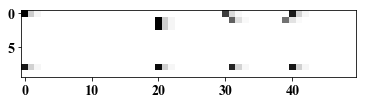

m (50, 10, 1)


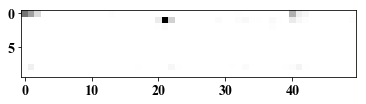

m (50, 10, 1)


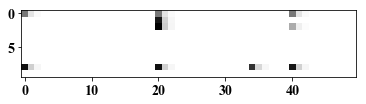

m (50, 10, 1)


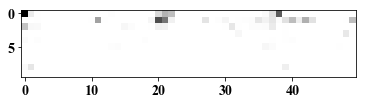

In [35]:
i,j = 240, 30
m = 50
y = vae.predict(x_train[:500])
plot.single(x_train[i,:m])
plot.single(y[i,:m])
plot.single(x_train[j,:m])
plot.single(y[j,:m])

m (50, 10, 1)


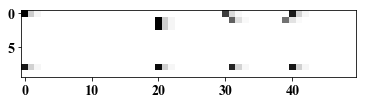

m (50, 10, 1)


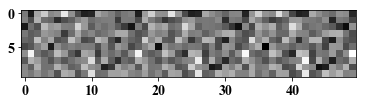

m (50, 10, 1)


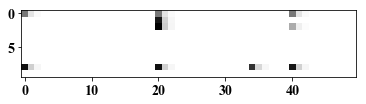

m (50, 10, 1)


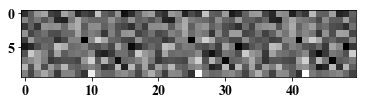

In [26]:
i,j = 0, 10
i,j = 240, 30

m = 50
y = vae.predict(x_train[:500])
plot.single(x_train[i,:m])
plot.single(y[i,:m])
plot.single(x_train[j,:m])
plot.single(y[j,:m])

In [29]:
# x = datagen.shuffle_3rd_dim_soft(x_train[:10], rate=1, intensity=2, scale=1, verbose=1)
# i = 0
# plot.single(x_train[i,:,:,0])
# plot.single(x[i,:,:,0])
# x_ = vae.predict(x)
# plot.single(x_[i,:,:,0])

In [30]:
# # min: these pixels are 'always' active
# m = x.min(axis=0)
# plot.multi(m[:30,:,0])

In [31]:
# # mean
# m = x.mean(axis=0)
# plot.single(m[:30,:,0])

## Encoder + Decoder (generator)
A model to project inputs on the latent space

In [32]:
# # build a model to project inputs on the latent space
# encoder = Model(encoder_input, z_mean)

In [33]:
# generator_input = Input((latent_dim,))
# generator_layers_ = utils.composition(decoders, generator_input)
# generator = Model(generator_input, generator_layers_)

In [34]:
decoder = generator

## Style transfer

In [35]:
import sklearn.feature_selection
import sklearn.ensemble

In [36]:
# pca = PCA(n_components=3)
# http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
# It uses the LAPACK implementation of the full SVD or a randomized truncated SVD by the method of Halko et al. 2009,
# depending on the shape of the input data and the number of components to extract.

In [37]:
m = 1000
x_train_encoded = encoder.predict(x_train[:m], batch_size=batch_size)
x_train_encoded.shape

(900, 10)

In [38]:
# a = list({3:[2],'s':[3,3]}.keys())
# np.random.shuffle(a)
# a

In [39]:
import transformation_extraction

In [40]:
d = {'a':3, 'b':2}
dd = np.array(list(d.keys()))

In [41]:
best_dims, importances, transformations, min_transformations = \
    transformation_extraction.between_genres(x_train_encoded, genre_dict, amt1=1000, amt2=1, v=1)


 Genre A: 07 Indie/05 Halftime 71BPM
  genre B: 	05 Jazz/02 Another You 170BPM (len: 7)
 	 i: 7, importance: 0.248984

 Genre A: 04 Country/08 Eddie Ed 111BPM
  genre B: 	04 Country/09 Broonze 122BPM (len: 7)
 	 i: 3, importance: 0.245765

 Genre A: 01 Rock n Roll/07 Domino 167BPM
  genre B: 	07 Indie/15 Tribal Shuffle 123BPM (len: 7)
 	 i: 9, importance: 0.278106

 Genre A: 05 Jazz/04 Silent Tear 234BPM
  genre B: 	01 Rock'n'Roll/06 Moonglow 140BPM (len: 7)
 	 i: 6, importance: 0.236138

 Genre A: 03 Traditional Pop/09 Distel 155BPM
  genre B: 	07 Indie/20 So Simple 102BPM (len: 7)
 	 i: 6, importance: 0.231831

 Genre A: 04 Country/01 Calvin 148BPM
  genre B: 	06 Soul - Funk/01 Soul Groove 107BPM (len: 7)
 	 i: 2, importance: 0.244365

 Genre A: 02 Blues/08 Sams 127BPM
  genre B: 	01 Rock n Roll/09 Rumblin 192BPM Triplets (len: 15)
 	 i: 8, importance: 0.170232

 Genre A: 01 Rock n Roll/03 Chucky 140BPM
  genre B: 	05 Jazz/06 Nucleus 172BPM Brushes (len: 7)
 	 i: 7, importance: 0.32

  genre B: 	02 Blues Rock/03 Fire 148BPM (len: 15)
 	 i: 9, importance: 0.304303

 Genre A: 01 Rock n Roll/08 Offkick 182BPM
  genre B: 	03 Traditional Pop/06 Bopop 130MPM (len: 7)
 	 i: 0, importance: 0.198925

 Genre A: 02 Blues Rock/06 Straight 130BPM
  genre B: 	07 Indie/12 Sticks Up 155BPM (len: 7)
 	 i: 4, importance: 0.181314

 Genre A: 07 Indie/07 Rock Keeler 133BPM
  genre B: 	07 Indie/06 Swing Funk 102BPM (len: 7)
 	 i: 7, importance: 0.166500

 Genre A: 07 Indie/13 Mid Groover 111BPM
  genre B: 	07 Indie/10 Chilled 120BPM (len: 7)
 	 i: 4, importance: 0.149353

 Genre A: 05 Jazz/01 Amel 85BPM Brushes
  genre B: 	05 Jazz/04 Silent Tear 234BPM (len: 7)
 	 i: 8, importance: 0.317056

 Genre A: 06 Soul - Funk/10 Syncopated Ride 128BPM
  genre B: 	04 Country/01 Calvin 148BPM (len: 7)
 	 i: 8, importance: 0.290816

 Genre A: 03 Traditional Pop/01 Fly High 115BPM
  genre B: 	06 Soul - Funk/09 Smooth Soul 81BPM (len: 7)
 	 i: 9, importance: 0.244595

 Genre A: 03 Traditional Pop/02 

  genre B: 	06 Soul - Funk/03 Cadence Soul 105BPM (len: 7)
 	 i: 4, importance: 0.255669

 Genre A: 05 Jazz/02 Another You 170BPM
  genre B: 	07 Indie/19 Distant Floor 119BPM (len: 7)
 	 i: 7, importance: 0.218670

 Genre A: 02 Blues/04 Mickeys 212BPM 12-8
  genre B: 	01 Rock n Roll/09 Rumblin 192BPM Triplets (len: 15)
 	 i: 2, importance: 0.164148

 Genre A: 03 Jazz/01 Swing 150BPM Triplets
  genre B: 	03 Traditional Pop/07 Lester Lee 133BPM (len: 7)
 	 i: 9, importance: 0.300242

 Genre A: 05 Jazz/08 Neodop 226BPM 3-4
  genre B: 	01 Rock'n'Roll/04 Maybelline 233BPM (len: 7)
 	 i: 4, importance: 0.209171

 Genre A: 04 Country/02 Marching 94BPM
  genre B: 	07 Indie/09 Slow Shuffle 80BPM (len: 7)
 	 i: 4, importance: 0.161184

 Genre A: 07 Indie/17 Relaxed 88BPM
  genre B: 	03 Traditional Pop/01 Fly High 115BPM (len: 7)
 	 i: 6, importance: 0.164214

 Genre A: 04 Country/09 Broonze 122BPM
  genre B: 	07 Indie/07 Rock Keeler 133BPM (len: 7)
 	 i: 9, importance: 0.288968

 Genre A: 07 Ind

  genre B: 	07 Indie/19 Distant Floor 119BPM (len: 7)
 	 i: 9, importance: 0.306196

 Genre A: 07 Indie/19 Distant Floor 119BPM
  genre B: 	02 Blues/07 Straight 88BPM (len: 7)
 	 i: 9, importance: 0.198874

 Genre A: 04 Country/07 Trainy 100BPM
  genre B: 	01 Rock'n'Roll/04 Maybelline 233BPM (len: 7)
 	 i: 7, importance: 0.237283

 Genre A: 03 Jazz/03 Gipsy 218BPM Triplets
  genre B: 	01 Rock'n'Roll/07 Thwag 170BPM (len: 7)
 	 i: 7, importance: 0.282942

 Genre A: 02 Blues Rock/05 Bluesshuffle 116BPM
  genre B: 	07 Indie/10 Chilled 120BPM (len: 7)
 	 i: 4, importance: 0.286137

 Genre A: 06 Soul - Funk/02 Boogaloo 120BPM
  genre B: 	07 Indie/15 Tribal Shuffle 123BPM (len: 7)
 	 i: 9, importance: 0.430557

 Genre A: 01 Rock n Roll/05 Diamond 164BPM
  genre B: 	07 Indie/19 Distant Floor 119BPM (len: 7)
 	 i: 0, importance: 0.235441

 Genre A: 07 Indie/02 Rock Tribal 125BPM
  genre B: 	03 Traditional Pop/06 Bopop 130MPM (len: 7)
 	 i: 4, importance: 0.258075

 Genre A: 07 Indie/15 Tribal 

  genre B: 	04 Country/04 Snarey 208BPM 3-4 (len: 7)
 	 i: 8, importance: 0.297466

 Genre A: 03 Traditional Pop/02 Frankies Girl 116BPM
  genre B: 	01 Rock n Roll/05 Diamond 164BPM (len: 15)
 	 i: 8, importance: 0.198730

 Genre A: 02 Blues Rock/01 Clutch 90BPM Triplets
  genre B: 	07 Indie/20 So Simple 102BPM (len: 7)
 	 i: 4, importance: 0.251934

 Genre A: 01 Rock'n'Roll/03 Lips n Hips 152BPM
  genre B: 	07 Indie/20 So Simple 102BPM (len: 7)
 	 i: 6, importance: 0.353196

 Genre A: 06 Soul - Funk/01 Soul Groove 107BPM
  genre B: 	03 Jazz/02 Boogaloo 170BPM Triplets (len: 15)
 	 i: 7, importance: 0.250712

 Genre A: 01 Rock'n'Roll/04 Maybelline 233BPM
  genre B: 	05 Jazz/10 Scalis 190BPM 3-4 (len: 7)
 	 i: 8, importance: 0.244620

 Genre A: 01 Rock n Roll/05 Diamond 164BPM
  genre B: 	03 Jazz/03 Gipsy 218BPM Triplets (len: 10)
 	 i: 5, importance: 0.219478

 Genre A: 06 Soul - Funk/04 GoGo Soul 100BPM
  genre B: 	01 Rock'n'Roll/09 Diddeley 185bpm (len: 7)
 	 i: 9, importance: 0.2725

  genre B: 	02 Blues/07 Straight 88BPM (len: 7)
 	 i: 9, importance: 0.301846

 Genre A: 01 Rock n Roll/02 Straight 150BPM
  genre B: 	01 Rock n Roll/01 Shuffle 186BPM (len: 15)
 	 i: 3, importance: 0.196082

 Genre A: 02 Blues/10 Bogeart 122BPM
  genre B: 	02 Blues Rock/09 Bluesballad 97BPM (len: 15)
 	 i: 4, importance: 0.327507

 Genre A: 06 Soul - Funk/08 Rim Soul 90BPM
  genre B: 	04 Country/04 Snarey 208BPM 3-4 (len: 7)
 	 i: 7, importance: 0.292712

 Genre A: 02 Blues/10 Bogeart 122BPM
  genre B: 	05 Jazz/08 Neodop 226BPM 3-4 (len: 7)
 	 i: 4, importance: 0.344876

 Genre A: 01 Rock n Roll/06 Swingin 132BPM Triplets
  genre B: 	06 Soul - Funk/09 Smooth Soul 81BPM (len: 7)
 	 i: 7, importance: 0.331803

 Genre A: 04 Country/05 Brewer 160BPM
  genre B: 	01 Rock'n'Roll/06 Moonglow 140BPM (len: 7)
 	 i: 6, importance: 0.262829

 Genre A: 03 Traditional Pop/04 Love 155BPM
  genre B: 	06 Soul - Funk/01 Soul Groove 107BPM (len: 7)
 	 i: 2, importance: 0.315871

 Genre A: 07 Indie/01 Ro

  genre B: 	07 Indie/12 Sticks Up 155BPM (len: 7)
 	 i: 8, importance: 0.193854

 Genre A: 03 Traditional Pop/07 Lester Lee 133BPM
  genre B: 	01 Rock'n'Roll/07 Thwag 170BPM (len: 7)
 	 i: 9, importance: 0.221769

 Genre A: 06 Soul - Funk/08 Rim Soul 90BPM
  genre B: 	06 Soul - Funk/04 GoGo Soul 100BPM (len: 7)
 	 i: 9, importance: 0.365781

 Genre A: 07 Indie/20 So Simple 102BPM
  genre B: 	02 Blues Rock/03 Fire 148BPM (len: 15)
 	 i: 7, importance: 0.251016

 Genre A: 02 Blues/04 Mickeys 212BPM 12-8
  genre B: 	01 Rock'n'Roll/05 Straight Line 136BPM (len: 7)
 	 i: 1, importance: 0.195686

 Genre A: 05 Jazz/01 Amel 85BPM Brushes
  genre B: 	05 Jazz/03 Cool 137BPM Brushes (len: 7)
 	 i: 1, importance: 0.238172

 Genre A: 01 Rock'n'Roll/08 Doowoop 140bpm
  genre B: 	03 Traditional Pop/09 Distel 155BPM (len: 7)
 	 i: 1, importance: 0.217613

 Genre A: 02 Blues Rock/04 Whiteroom 112BPM
  genre B: 	07 Indie/08 Bouncer 162BPM (len: 7)
 	 i: 0, importance: 0.232724

 Genre A: 07 Indie/15 Tri

  genre B: 	06 Soul - Funk/02 Boogaloo 120BPM (len: 7)
 	 i: 3, importance: 0.241016

 Genre A: 05 Jazz/03 Cool 137BPM Brushes
  genre B: 	02 Blues/04 Mickeys 212BPM 12-8 (len: 7)
 	 i: 1, importance: 0.242410

 Genre A: 05 Jazz/09 West Coast 152BPM Brushes
  genre B: 	04 Country/08 Eddie Ed 111BPM (len: 7)
 	 i: 7, importance: 0.237423

 Genre A: 05 Jazz/02 Another You 170BPM
  genre B: 	02 Blues/09 Leroyes 130BPM (len: 7)
 	 i: 9, importance: 0.235168

 Genre A: 07 Indie/08 Bouncer 162BPM
  genre B: 	03 Jazz/02 Boogaloo 170BPM Triplets (len: 15)
 	 i: 5, importance: 0.230692

 Genre A: 01 Rock'n'Roll/01 Dancin Rick 166BPM
  genre B: 	04 Country/06 Booker 170BPM (len: 7)
 	 i: 9, importance: 0.286630

 Genre A: 04 Country/04 Snarey 208BPM 3-4
  genre B: 	02 Blues/06 Vidar Vega 70BPM (len: 7)
 	 i: 7, importance: 0.225002

 Genre A: 07 Indie/20 So Simple 102BPM
  genre B: 	02 Blues/01 Booze 92BPM (len: 7)
 	 i: 4, importance: 0.277509

 Genre A: 04 Country/02 Marching 94BPM
  genre B: 

  genre B: 	01 Rock'n'Roll/03 Lips n Hips 152BPM (len: 7)
 	 i: 2, importance: 0.199540

 Genre A: 07 Indie/10 Chilled 120BPM
  genre B: 	05 Jazz/02 Another You 170BPM (len: 7)
 	 i: 7, importance: 0.277645

 Genre A: 07 Indie/09 Slow Shuffle 80BPM
  genre B: 	06 Soul - Funk/07 Ride Swing 95Bpm (len: 7)
 	 i: 9, importance: 0.198117

 Genre A: 05 Jazz/07 Kooper 234BPM
  genre B: 	01 Rock n Roll/08 Offkick 182BPM (len: 15)
 	 i: 9, importance: 0.256721

 Genre A: 06 Soul - Funk/10 Syncopated Ride 128BPM
  genre B: 	02 Blues Rock/10 Uptime 150BPM (len: 15)
 	 i: 9, importance: 0.318629

 Genre A: 03 Jazz/02 Boogaloo 170BPM Triplets
  genre B: 	07 Indie/20 So Simple 102BPM (len: 7)
 	 i: 6, importance: 0.373240

 Genre A: 01 Rock'n'Roll/04 Maybelline 233BPM
  genre B: 	07 Indie/09 Slow Shuffle 80BPM (len: 7)
 	 i: 0, importance: 0.175559

 Genre A: 07 Indie/17 Relaxed 88BPM
  genre B: 	04 Country/04 Snarey 208BPM 3-4 (len: 7)
 	 i: 8, importance: 0.175229

 Genre A: 01 Rock n Roll/07 Domi

  genre B: 	02 Blues Rock/09 Bluesballad 97BPM (len: 15)
 	 i: 0, importance: 0.267056

 Genre A: 01 Rock n Roll/09 Rumblin 192BPM Triplets
  genre B: 	07 Indie/04 Titanic 97BPM (len: 7)
 	 i: 7, importance: 0.292508

 Genre A: 06 Soul - Funk/05 Hip Hop 95BPM
  genre B: 	02 Blues Rock/10 Uptime 150BPM (len: 15)
 	 i: 7, importance: 0.248978

 Genre A: 02 Blues Rock/02 Sixeight 58BPM
  genre B: 	06 Soul - Funk/07 Ride Swing 95Bpm (len: 7)
 	 i: 8, importance: 0.274743

 Genre A: 03 Traditional Pop/08 Cecil Cee 101BPM
  genre B: 	03 Traditional Pop/03 King Quiza 102BPM (len: 7)
 	 i: 1, importance: 0.200698

 Genre A: 01 Rock n Roll/01 Shuffle 186BPM
  genre B: 	02 Blues/05 Cadillac 128BPM (len: 7)
 	 i: 9, importance: 0.318987

 Genre A: 07 Indie/17 Relaxed 88BPM
  genre B: 	03 Traditional Pop/06 Bopop 130MPM (len: 7)
 	 i: 5, importance: 0.244398

 Genre A: 01 Rock'n'Roll/09 Diddeley 185bpm
  genre B: 	01 Rock'n'Roll/04 Maybelline 233BPM (len: 7)
 	 i: 4, importance: 0.228160

 Genre A

  genre B: 	07 Indie/07 Rock Keeler 133BPM (len: 7)
 	 i: 7, importance: 0.163939

 Genre A: 02 Blues/08 Sams 127BPM
  genre B: 	03 Traditional Pop/05 Your Eyes 80BPM (len: 7)
 	 i: 6, importance: 0.184327

 Genre A: 07 Indie/16 Medium Flow 120BPM
  genre B: 	07 Indie/18 Disco Weirdo 146BPM (len: 7)
 	 i: 4, importance: 0.159930

 Genre A: 07 Indie/16 Medium Flow 120BPM
  genre B: 	01 Rock n Roll/08 Offkick 182BPM (len: 15)
 	 i: 1, importance: 0.208725

 Genre A: 02 Blues/09 Leroyes 130BPM
  genre B: 	02 Blues/07 Straight 88BPM (len: 7)
 	 i: 2, importance: 0.281140

 Genre A: 02 Blues/06 Vidar Vega 70BPM
  genre B: 	07 Indie/14 Disco Smooth 97BPM (len: 7)
 	 i: 9, importance: 0.201048

 Genre A: 04 Country/09 Broonze 122BPM
  genre B: 	02 Blues/07 Straight 88BPM (len: 7)
 	 i: 2, importance: 0.220029

 Genre A: 07 Indie/10 Chilled 120BPM
  genre B: 	01 Rock n Roll/08 Offkick 182BPM (len: 15)
 	 i: 6, importance: 0.305057

 Genre A: 01 Rock n Roll/10 Uptime 112BPM
  genre B: 	02 Blues

  genre B: 	04 Country/03 Straight 72BPM Brushes (len: 7)
 	 i: 2, importance: 0.228923

 Genre A: 01 Rock n Roll/09 Rumblin 192BPM Triplets
  genre B: 	04 Country/01 Calvin 148BPM (len: 7)
 	 i: 7, importance: 0.240972

 Genre A: 05 Jazz/08 Neodop 226BPM 3-4
  genre B: 	01 Rock'n'Roll/09 Diddeley 185bpm (len: 7)
 	 i: 2, importance: 0.196000

 Genre A: 06 Soul - Funk/01 Soul Groove 107BPM
  genre B: 	01 Rock'n'Roll/03 Lips n Hips 152BPM (len: 7)
 	 i: 2, importance: 0.289468

 Genre A: 07 Indie/01 Rock Shuffle 130BPM
  genre B: 	03 Traditional Pop/07 Lester Lee 133BPM (len: 7)
 	 i: 9, importance: 0.204581

 Genre A: 02 Blues/07 Straight 88BPM
  genre B: 	02 Blues Rock/02 Sixeight 58BPM (len: 15)
 	 i: 7, importance: 0.366469

 Genre A: 04 Country/07 Trainy 100BPM
  genre B: 	04 Country/08 Eddie Ed 111BPM (len: 7)
 	 i: 7, importance: 0.185258

 Genre A: 02 Blues/07 Straight 88BPM
  genre B: 	01 Rock n Roll/10 Uptime 112BPM (len: 15)
 	 i: 9, importance: 0.175196

 Genre A: 06 Soul - 

  genre B: 	06 Soul - Funk/09 Smooth Soul 81BPM (len: 7)
 	 i: 7, importance: 0.291926

 Genre A: 04 Country/02 Marching 94BPM
  genre B: 	02 Blues Rock/05 Bluesshuffle 116BPM (len: 15)
 	 i: 7, importance: 0.325216

 Genre A: 02 Blues/07 Straight 88BPM
  genre B: 	02 Blues Rock/05 Bluesshuffle 116BPM (len: 15)
 	 i: 7, importance: 0.403141

 Genre A: 04 Country/03 Straight 72BPM Brushes
  genre B: 	05 Jazz/06 Nucleus 172BPM Brushes (len: 7)
 	 i: 8, importance: 0.243215

 Genre A: 02 Blues Rock/04 Whiteroom 112BPM
  genre B: 	04 Country/05 Brewer 160BPM (len: 7)
 	 i: 9, importance: 0.280213

 Genre A: 02 Blues/08 Sams 127BPM
  genre B: 	01 Rock n Roll/04 Deddley 150BPM (len: 15)
 	 i: 8, importance: 0.160968

 Genre A: 01 Rock'n'Roll/02 Gogo 191BPM
  genre B: 	05 Jazz/07 Kooper 234BPM (len: 7)
 	 i: 2, importance: 0.169624

 Genre A: 07 Indie/18 Disco Weirdo 146BPM
  genre B: 	01 Rock n Roll/04 Deddley 150BPM (len: 15)
 	 i: 8, importance: 0.166650

 Genre A: 06 Soul - Funk/08 Rim So

  genre B: 	03 Traditional Pop/02 Frankies Girl 116BPM (len: 7)
 	 i: 9, importance: 0.251098

 Genre A: 06 Soul - Funk/05 Hip Hop 95BPM
  genre B: 	03 Jazz/02 Boogaloo 170BPM Triplets (len: 15)
 	 i: 3, importance: 0.298725

 Genre A: 02 Blues Rock/06 Straight 130BPM
  genre B: 	07 Indie/03 Moon 137BPM (len: 7)
 	 i: 6, importance: 0.136400

 Genre A: 01 Rock n Roll/03 Chucky 140BPM
  genre B: 	02 Blues/01 Booze 92BPM (len: 7)
 	 i: 7, importance: 0.200851

 Genre A: 06 Soul - Funk/07 Ride Swing 95Bpm
  genre B: 	01 Rock n Roll/04 Deddley 150BPM (len: 15)
 	 i: 9, importance: 0.183078

 Genre A: 01 Rock'n'Roll/07 Thwag 170BPM
  genre B: 	01 Rock n Roll/04 Deddley 150BPM (len: 15)
 	 i: 3, importance: 0.185299

 Genre A: 04 Country/02 Marching 94BPM
  genre B: 	07 Indie/17 Relaxed 88BPM (len: 7)
 	 i: 8, importance: 0.187377

 Genre A: 01 Rock n Roll/03 Chucky 140BPM
  genre B: 	01 Rock n Roll/09 Rumblin 192BPM Triplets (len: 15)
 	 i: 9, importance: 0.183855

 Genre A: 06 Soul - Funk/

  genre B: 	02 Blues Rock/03 Fire 148BPM (len: 15)
 	 i: 9, importance: 0.313677

 Genre A: 02 Blues/10 Bogeart 122BPM
  genre B: 	03 Traditional Pop/03 King Quiza 102BPM (len: 7)
 	 i: 8, importance: 0.269366

 Genre A: 03 Traditional Pop/06 Bopop 130MPM
  genre B: 	02 Blues Rock/08 Shuffle 119BPM Triplets (len: 15)
 	 i: 5, importance: 0.240719

 Genre A: 03 Traditional Pop/04 Love 155BPM
  genre B: 	02 Blues Rock/03 Fire 148BPM (len: 15)
 	 i: 9, importance: 0.290876

 Genre A: 03 Traditional Pop/05 Your Eyes 80BPM
  genre B: 	06 Soul - Funk/02 Boogaloo 120BPM (len: 7)
 	 i: 3, importance: 0.330511

 Genre A: 01 Rock'n'Roll/01 Dancin Rick 166BPM
  genre B: 	05 Jazz/10 Scalis 190BPM 3-4 (len: 7)
 	 i: 4, importance: 0.294172

 Genre A: 01 Rock n Roll/02 Straight 150BPM
  genre B: 	03 Jazz/02 Boogaloo 170BPM Triplets (len: 15)
 	 i: 7, importance: 0.293119

 Genre A: 07 Indie/20 So Simple 102BPM
  genre B: 	05 Jazz/05 TNT 116BPM (len: 7)
 	 i: 7, importance: 0.211439

 Genre A: 01 Roc

  genre B: 	01 Rock n Roll/10 Uptime 112BPM (len: 15)
 	 i: 6, importance: 0.235417

 Genre A: 07 Indie/11 Disco Dancer 135BPM
  genre B: 	07 Indie/12 Sticks Up 155BPM (len: 7)
 	 i: 4, importance: 0.212888

 Genre A: 03 Jazz/01 Swing 150BPM Triplets
  genre B: 	06 Soul - Funk/10 Syncopated Ride 128BPM (len: 7)
 	 i: 9, importance: 0.458147

 Genre A: 01 Rock n Roll/02 Straight 150BPM
  genre B: 	01 Rock'n'Roll/07 Thwag 170BPM (len: 7)
 	 i: 5, importance: 0.248682

 Genre A: 07 Indie/11 Disco Dancer 135BPM
  genre B: 	01 Rock n Roll/03 Chucky 140BPM (len: 15)
 	 i: 9, importance: 0.187387

 Genre A: 03 Jazz/02 Boogaloo 170BPM Triplets
  genre B: 	01 Rock'n'Roll/03 Lips n Hips 152BPM (len: 7)
 	 i: 2, importance: 0.208935

 Genre A: 04 Country/03 Straight 72BPM Brushes
  genre B: 	05 Jazz/01 Amel 85BPM Brushes (len: 7)
 	 i: 7, importance: 0.253564

 Genre A: 05 Jazz/07 Kooper 234BPM
  genre B: 	07 Indie/08 Bouncer 162BPM (len: 7)
 	 i: 9, importance: 0.283139

 Genre A: 01 Rock n Roll

In [42]:
print('avg importance: %f' % np.mean(importances))

avg importance: 0.246087


In [43]:
# list(min_transformations.items())[0]

In [44]:
for genre_A, d in min_transformations.items():
    print('\nGenre `%s` to: \n dim:\tgenre:' % genre_A)
    for genre_B, vector in d.items():
        print(' %i \t%s' % (np.argmax(vector), genre_B))  


Genre `07 Indie/05 Halftime 71BPM` to: 
 dim:	genre:
 0 	05 Jazz/02 Another You 170BPM

Genre `04 Country/08 Eddie Ed 111BPM` to: 
 dim:	genre:
 0 	02 Blues/05 Cadillac 128BPM

Genre `01 Rock n Roll/07 Domino 167BPM` to: 
 dim:	genre:
 0 	06 Soul - Funk/10 Syncopated Ride 128BPM

Genre `05 Jazz/04 Silent Tear 234BPM` to: 
 dim:	genre:
 5 	04 Country/10 Rough Rider 183BPM

Genre `03 Traditional Pop/09 Distel 155BPM` to: 
 dim:	genre:
 4 	06 Soul - Funk/03 Cadence Soul 105BPM

Genre `04 Country/01 Calvin 148BPM` to: 
 dim:	genre:
 0 	02 Blues/07 Straight 88BPM

Genre `02 Blues/08 Sams 127BPM` to: 
 dim:	genre:
 0 	03 Traditional Pop/05 Your Eyes 80BPM

Genre `01 Rock n Roll/03 Chucky 140BPM` to: 
 dim:	genre:
 8 	02 Blues/08 Sams 127BPM

Genre `04 Country/04 Snarey 208BPM 3-4` to: 
 dim:	genre:
 2 	06 Soul - Funk/10 Syncopated Ride 128BPM

Genre `06 Soul - Funk/01 Soul Groove 107BPM` to: 
 dim:	genre:
 2 	02 Blues/01 Booze 92BPM

Genre `02 Blues/07 Straight 88BPM` to: 
 dim:	genre:
 9 	

(array([ 86.,  46.,  86.,  42.,  97.,  54.,  93., 161., 101., 229.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

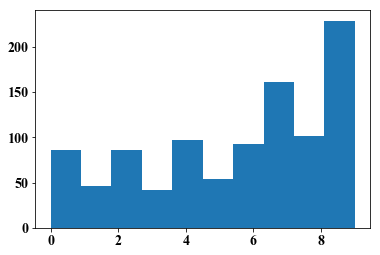

In [45]:
plt.hist(best_dims)

In [46]:
# TODO save as python object (or json)

In [47]:
# def save_transformation_dicts(transformations={}, dn='', v=0):
#     for genre_A, sub_dict in transformations.items():
#         # sub_dict :: {'genre_B_2/genre_B_2': vector}
#         a1, a2 = genre_A.split('/')
#         if a1 not in os.listdir(dn): os.mkdir(dn + a1)
#         if v:
#             print(genre_A)
#             print(sub_dict.keys())
#         io.save_dict(dn + a1, a2, sub_dict)

fn = config.plots_dir + 'transformations-best_dims.pkl'
io.save(best_dims, fn)

fn = config.plots_dir + 'transformations.pkl'
io.save(transformations, fn)

fn = config.plots_dir + 'min_transformations.pkl'
io.save(min_transformations, fn)

'../results/min_transformations.pkl'

In [48]:
t_ = io.load(fn)

In [49]:
# transformations = io.read_categorical_dict_dir(config.plots_dir + 'transformations/')
# min_transformations = io.read_categorical_dict_dir(config.plots_dir + 'min_transformations/') 

In [50]:
list(transformations.keys())[:3]

['07 Indie/05 Halftime 71BPM',
 '04 Country/08 Eddie Ed 111BPM',
 '01 Rock n Roll/07 Domino 167BPM']

In [51]:
len(transformations.keys())

103